In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
chars = sorted(set("".join(words)))
stoi = {char: i + 1 for i, char in enumerate(chars)}
stoi["."] = 0
itos = {i: char for char, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
block_size = 3


def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for char in w + ".":
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

In [26]:
ALPHABET_SIZE = len(itos)
embdding_size = 10
l1_input_size = block_size * embdding_size
l1_neurons = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((ALPHABET_SIZE, embdding_size), requires_grad=True, generator=g)
W1 = torch.randn((l1_input_size, l1_neurons), requires_grad=True, generator=g)
b1 = torch.randn((l1_neurons), requires_grad=True, generator=g)
W2 = torch.randn((l1_neurons, ALPHABET_SIZE), requires_grad=True, generator=g)
b2 = torch.randn((ALPHABET_SIZE), requires_grad=True, generator=g)
params = [C, W1, b1, W2, b2]

sum([p.nelement() for p in params])

11897

In [29]:
lossi = []
stepi = []

runs = 200_000
batch_size = 32

for i in range(runs):

    # minibatch
    ix = torch.randint(0, Xtrain.shape[0], (batch_size,))
    emb = C[Xtrain[ix]]
    h = torch.tanh(emb.view(-1, l1_input_size) @ W1 + b1)
    logits = h @ W2 + b2

    loss = F.cross_entropy(logits, Ytrain[ix])

    for p in params:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100_0000 else 0.01
    with torch.no_grad():
        for p in params:
            p -= lr * p.grad

    with torch.no_grad():
        lossi.append(loss.log10().item())
        stepi.append(i)

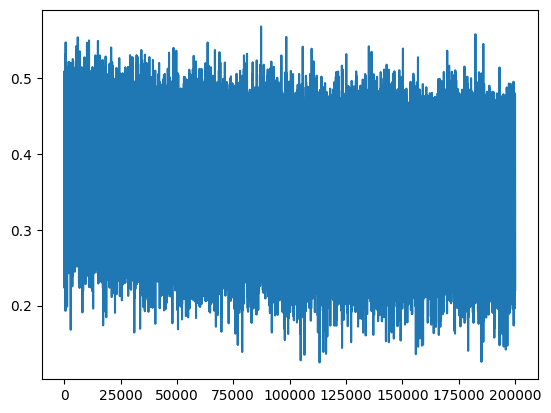

In [30]:
plt.plot(stepi, lossi)

In [31]:
for xs, ys in zip([Xtrain, Xdev, Xtest], [Ytrain, Ydev, Ytest]):
    emb = C[xs]
    h = torch.tanh(emb.view(-1, l1_input_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, ys)
    print(loss.item())

2.2627103328704834
2.3207108974456787
2.316173791885376


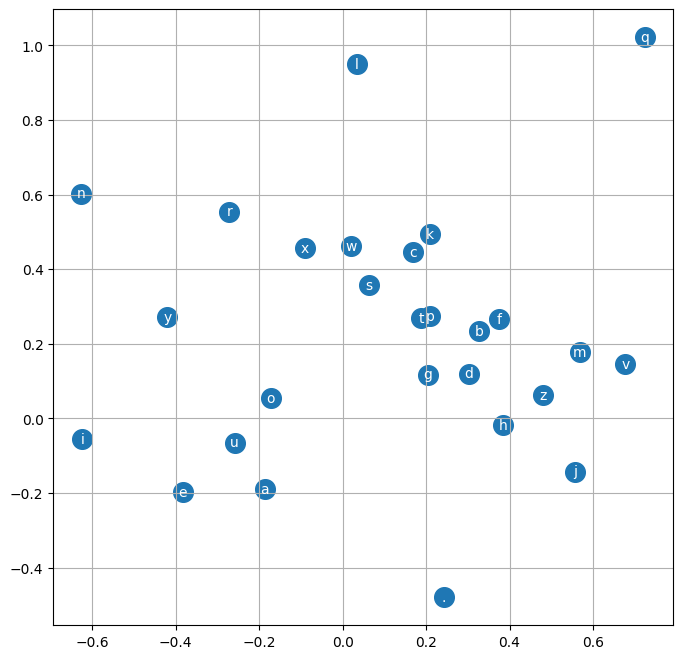

In [24]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(
        C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white"
    )
plt.grid("minor")

In [32]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join(itos[i] for i in out))

chriz.
fate.
heri.
kemri.
reh.
jahman.
ske.
rah.
brie.
kryst.
kaeli.
jermari.
chrihvon.
leigh.
ham.
join.
quintza.
lilea.
jaqua.
reje.
